# A Network Approach --
Michael Ying

Fall '23 S&DS 491 Senior Thesis

Advised by Gisela Gabernet and Steven Kleinstein

### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import Levenshtein 
from scipy.spatial.distance import pdist, squareform
import scipy
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


import warnings
# warnings.filterwarnings(action="once") # doesn't work?
warnings.filterwarnings("ignore") # careful

# my .py files
import my_stats 
import manual_lisi as my_lisi
import my_distance_metrics as my_dist
import data_processing as my_data

# Data Processing

### Read in data

#### Patient Data

In [99]:
# grab patient data
cols = ["sequence_id", "sample_id", "subject_id", "clone_id", "v_call", "j_call", "junction_aa", "junction_length", "locus"]

full_patient_data = my_data.extract_data(data_directory = "data/IGHV1_58_repertoires", keep_columns=cols) 
patient_data = my_data.process_data(full_patient_data)
patient_data["data_type"] = "patient"
# print(full_patient_data.shape)
print(patient_data.shape)

raw size: (32248, 9)
shape after filter IGH locus and IGHV1-58 v-call: (32248, 9)
shape after removing (subject, junction_aa_clipped) dupes: (17186, 10)
shape after removing subjects with <10 (unique) sequences: (17144, 10)
(17144, 12)


#### Healthy Control data

In [100]:
# grab healthy control data
cols = ["sequence_id", "sample_id", "subject_id", "clone_id", "v_call", "j_call", "junction_aa", "junction_length", "locus", "study_group_description"]
filter_tuples = [("study_group_description", "Control", "str_contains")]

full_control_data = my_data.extract_data(data_directory = "data/control_data", keep_columns = cols, column_filters = filter_tuples) 
control_data = my_data.process_data(full_control_data)
control_data["data_type"] = "control"
# control_data.shape

raw size: (6302159, 10)
shape after filter IGH locus and IGHV1-58 v-call: (12080, 10)
shape after removing (subject, junction_aa_clipped) dupes: (5830, 11)
shape after removing subjects with <10 (unique) sequences: (5680, 11)


#### Combine patient and control data

In [103]:

combined_data = pd.concat((patient_data, control_data))
combined_data["node_label"] = list(range(0,combined_data.shape[0],1))

combined_data.shape

(22824, 13)

In [104]:
# check unique j_calls
print(np.unique(control_data["j_call"]))
print(np.unique(combined_data["j_call"]))

['IGHJ1' 'IGHJ2' 'IGHJ3' 'IGHJ4' 'IGHJ5' 'IGHJ6']
['IGHJ1' 'IGHJ2' 'IGHJ3' 'IGHJ4' 'IGHJ5' 'IGHJ6']


In [143]:
# check number of patients
temp_df = patient_data
temp_df["subject_id"] = temp_df["subject_id"].astype(str)
print(len(np.unique(temp_df["subject_id"])))

temp_df = control_data
temp_df["subject_id"] = temp_df["subject_id"].astype(str)
print(len(np.unique(temp_df["subject_id"])))

temp_df = combined_data
temp_df["subject_id"] = temp_df["subject_id"].astype(str)
print(len(np.unique(temp_df["subject_id"])))


68
39
107


#### Annotated Data
Source: 

In [105]:
# grab annotated data
annotated_data = my_data.process_annotated_data(file_path="data/CoV-AbDab_130623.csv")
annotated_sequences = set(annotated_data["CDRH3"])

print(len(annotated_sequences)) # 128 unique sequences

128


In [106]:
annotated_data.head()

,Name,Ab or Nb,Heavy V Gene,Heavy J Gene,Light V Gene,Light J Gene,CDRH3,CDRH3_length
78,P10S-1D8,Ab,IGHV1-58,IGHJ3,IGKV3-20,IGKJ3,AAPGCNSTSCYDGFDI,16.0
307,029-2C7,Ab,IGHV1-58,IGHJ1,IGLV7-46,IGLJ2,AADLGGPEYFQH,12.0
414,Ab496,Ab,IGHV1-58,IGHJ5,IGKV1-33,IGKJ3,AAFPYYYDNSGSGP,14.0
507,B1026,Ab,IGHV1-58,IGHJ3,IGKV3-20,IGKJ1,ATNHCSRTICSDGFDI,16.0
515,AZ090,Ab,IGHV1-58,IGHJ3,IGKV3-42,IGKJ1,AAPYCNKTNCRDGFDM,16.0


### Graph Construction

We construct graphs where nodes are sequences and edges are normalized Levenshtein distances between the CDRH3 sequences. We only add edges when two nodes have the same V call and the distance is below an edge threshold. 

In [110]:
# ----- constructing full graph (with patient and healthy data) ----- #
df = combined_data # full dataset to use

edge_threshold = 0.2 # threshold used for edges
distance_func = my_dist.levenshtein_distance_norm

unique_j_genes = np.unique(df["j_call"])

G_full = nx.Graph() # init empty graph

for j_gene_group in unique_j_genes:
    # grab sequences
    j_gene_filtered_data = df[df["j_call"] == j_gene_group]

    # create small subgraph with edge threshold; merge into main graph
    j_gene_t_graph = nx.Graph()

    # process each new sequence (row in df)
    for index, row in j_gene_filtered_data.iterrows():
        # --- add new node --- #
        # grab node data
        node_label = row["node_label"]
        node_seq = row["junction_aa_clipped"]
        node_subject_id = row["subject_id"]
        data_type = row["data_type"]
        node_v_call = row["v_call"]
        node_j_call = row["j_call"]

        # store in dict
        node_attr_dict = {}
        node_attr_dict["junction_aa_clipped"] = node_seq
        node_attr_dict["subject_id"] = node_subject_id
        node_attr_dict["data_type"] = data_type
        node_attr_dict["v_call"] = node_v_call
        node_attr_dict["j_call"] = node_j_call

        # add node to graph
        node_tuple = (node_label, node_attr_dict)
        j_gene_t_graph.add_nodes_from([node_tuple]) 

        # --- add edges to existing nodes if under threshold --- #
        for existing_node in j_gene_t_graph.nodes:
            # no self-edges
            if existing_node != node_label:
                # add edge + edge atributes
                existing_node_seq = j_gene_t_graph.nodes[existing_node]["junction_aa_clipped"]
                node2node_dist = distance_func(existing_node_seq, node_seq, edge_cutoff=edge_threshold) # Levenshtein

                if node2node_dist <= edge_threshold:
                    # add new edge
                    j_gene_t_graph.add_edge(existing_node, node_label, weight=node2node_dist)

                    # edge dist for other attributes (for clustering)
                    edge_dist = j_gene_t_graph[existing_node][node_label]["weight"] 

                    j_gene_t_graph[existing_node][node_label]["linear_similarity"] = 1.5*edge_threshold - edge_dist
                    j_gene_t_graph[existing_node][node_label]["exp_similarity"] = np.exp(-1.5*edge_dist)

    # delete small CCs
    j_gene_t_graph_temp = j_gene_t_graph.copy()
    for cc in nx.connected_components(j_gene_t_graph_temp):
        if len(cc) < 10:
            j_gene_t_graph.remove_nodes_from(cc)

    # graph union
    G_full = nx.union(G_full, j_gene_t_graph)


In [108]:
len(G_full.nodes)

8976

### Graph Exploratory Data Analysis

#### Sequence length distribution

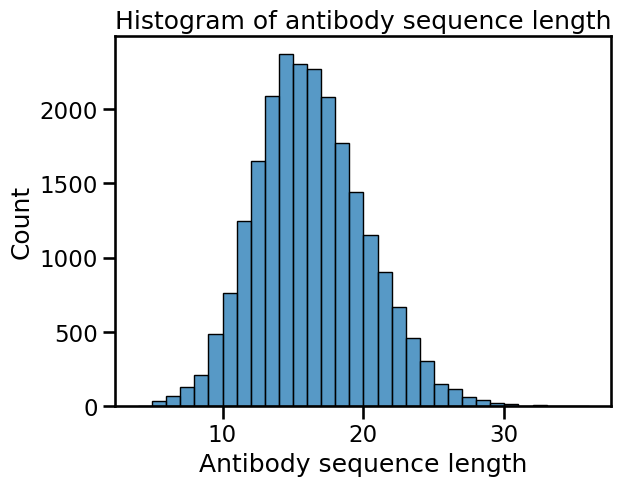

In [150]:
sequences = list(combined_data["junction_aa_clipped"])
sequence_len = [len(s) for s in sequences]

sns.histplot(sequence_len, binwidth=1)
plt.title("Histogram of antibody sequence length")
plt.xlabel("Antibody sequence length")
# plt.savefig("plots/seq_length_dist.png", bbox_inches='tight', dpi=300)
plt.show()

#### Print out connected components

In [151]:
# use data_type = annotated, control, or patient
def print_subgraph(subgraph, id, file_path, partition_id="default"):

    # find all non-annotated/control subject ids
    patient_subject_id_set = set()
    for node in subgraph.nodes:
        if subgraph.nodes[node]["data_type"] == "patient":
            patient_subject_id_set.add(subgraph.nodes[node]["subject_id"])
    
    n_unique_patient_subject_ids = len(patient_subject_id_set)

    # colors only for patient nodes
    colors = sns.color_palette("viridis", n_colors = n_unique_patient_subject_ids)
    color_mapping = dict(zip(patient_subject_id_set, colors))

    # get list of colors for nodes
    node_color_list = []
    for node in subgraph.nodes:
        if subgraph.nodes[node]["data_type"] == "patient":
            node_subject_id = subgraph.nodes[node]["subject_id"]
            node_color_list.append(color_mapping[node_subject_id])
        elif subgraph.nodes[node]["data_type"] == "annotated":
            node_color_list.append((255/256, 0, 0)) # red
        elif subgraph.nodes[node]["data_type"] == "control":
            node_color_list.append((0, 0, 0)) # black 
        else:
            print("careful: unknown data type encountered")
            node_color_list.append((0, 0, 0))

    # print(f"cc id {id}")
    nx.draw_networkx(subgraph, node_size=40, width=0.5, with_labels=False, node_color = node_color_list)
    # plt.savefig(f"{file_path}/{partition_id}_cc{id}.png", dpi=300)
    plt.close()


In [152]:
# ----- graph connected components ----- #
# inputs: graph, partition (sets of nodes), and partition_id to be used for file saving
def plot_all_clusters(graph, partition, file_path, partition_id):
    cc_id = 0
    for group in partition:
        # add annotated sequences to make an augmented subgraph
        temp_cc_subgraph = graph.subgraph(group)

        for cc in nx.connected_components(temp_cc_subgraph):
            # this one gets changed
            augmented_cc_subgraph = temp_cc_subgraph.subgraph(cc).copy()

            # list of existing non-annotated nodes
            existing_nodes = cc 

            if len(existing_nodes) < 10:
                continue # to next connected component

            # check against annotated, add them in
            for seq in annotated_sequences:
                # add seq to graph
                augmented_cc_subgraph.add_node(seq, 
                                            junction_aa_clipped = seq,           # sequence name for node id for now.
                                            data_type = "annotated",
                                            subject_id = "annotated_subject"     # can change, but this data doesn't match ours
                                            )

                # add edges to nodes if close enough
                for node in existing_nodes:
                    seq2node_dist = distance_func(seq, augmented_cc_subgraph.nodes[node]["junction_aa_clipped"], edge_cutoff=edge_threshold)
                    if seq2node_dist < edge_threshold:
                        augmented_cc_subgraph.add_edge(seq, node, weight=seq2node_dist)

            # remove clusters of new graph with only annotated sequence nodes
            augmented_cc_subgraph_copy = augmented_cc_subgraph.copy()
            for c in nx.connected_components(augmented_cc_subgraph_copy):
                delete_c = True
                for node in c:
                    if augmented_cc_subgraph_copy.nodes[node]["data_type"] != "annotated":
                        delete_c = False # no longer want to delete
                        continue # speed check
            
                # if delete_c still true, this means all nodes in c are annotated
                if delete_c == True:
                    augmented_cc_subgraph.remove_nodes_from(c)
        
            # print out
            print_subgraph(augmented_cc_subgraph, cc_id, file_path, partition_id)

            cc_id += 1



In [40]:
# ----- plots all ccs ----- #
# plot_all_clusters(G_full, nx.connected_components(G_full), "intro_cluster_images", "nxcc")

### Examine Louvain resolution and graph properties

In [55]:
# parameters
G = G_full
resolutions = [0.8, 1.0, 2.0, 3.0, 5.0, 8.0, 20.0]

# list out # unique subjects, count, and wasserstein mover's distance (un-normalized? more weight on bigger distributions?)
# same order as resolutions
master_n_unique_subjects = []
master_size = []
master_size_no_smalls = []
master_wasserstein = []
master_seq_variance = []

# looping over connected components of main graph
for res in resolutions:
    res_n_unique_subject_dist = []
    res_cluster_size_dist = [] # contains smalls
    res_cluster_size_dist_no_smalls = [] # no smalls
    res_cluster_wasserstein_dist = [] # with mode; mathematically not ideal? but can't find something like it
    res_cluster_seq_variance = []

    for cc in nx.connected_components(G):
        cc_subgraph = G.subgraph(cc)
        louvain_partition = nx.community.louvain_communities(cc_subgraph, weight="linear_similarity", resolution = res, seed=17) 

        # currently ignoring if louvain returns disjointed clusters
        for community in louvain_partition:
            # all sizes
            res_cluster_size_dist.append(len(community))

            # n unique subjects, wasserstein of sequence length
            if len(community) >= 10:
                community_subgraph = cc_subgraph.subgraph(community)

                # no small sizes
                res_cluster_size_dist_no_smalls.append(len(community))

                # n unique subjects
                community_subject_ids = nx.get_node_attributes(community_subgraph, "subject_id")
                unique_subjects_set = set(community_subject_ids.values())
                res_n_unique_subject_dist.append(len(unique_subjects_set))

                # wasserstein distance
                community_sequences = nx.get_node_attributes(community_subgraph, "junction_aa_clipped")
                sequence_lengths = [len(seq) for seq in community_sequences.values()]
                mode_length = [scipy.stats.mode(sequence_lengths).mode] # extract mode
                wasserstein_dist = scipy.stats.wasserstein_distance(sequence_lengths, mode_length)
                res_cluster_wasserstein_dist.append(wasserstein_dist)

                # sequence length variance
                res_cluster_seq_variance.append(np.var(sequence_lengths))

    # add to master data lists
    master_n_unique_subjects.append(res_n_unique_subject_dist)
    master_size.append(res_cluster_size_dist)
    master_size_no_smalls.append(res_cluster_size_dist_no_smalls)
    master_wasserstein.append(res_cluster_wasserstein_dist)
    master_seq_variance.append(res_cluster_seq_variance)

In [128]:
# wasserstein distance of wasserstein distance distribution from 0
res_to_wass_score = dict()
for wass_dist, res in zip(master_wasserstein, resolutions):
    score = scipy.stats.wasserstein_distance(wass_dist, [0])
    res_to_wass_score[res] = score

print(res_to_wass_score)

{0.8: 1.9188510205193214, 1.0: 1.9180338412154687, 2.0: 1.9757136393877053, 3.0: 1.9176021054004073, 5.0: 1.903605635698182, 8.0: 1.9118810102937513, 20.0: 1.7900018269448257}


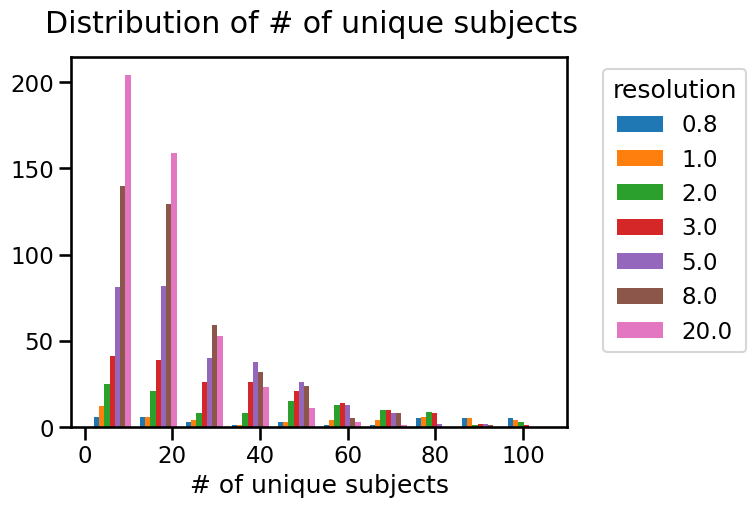

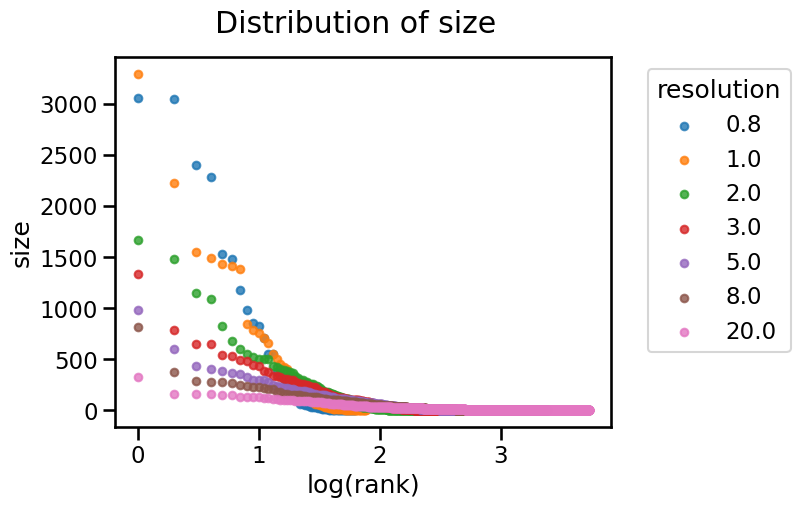

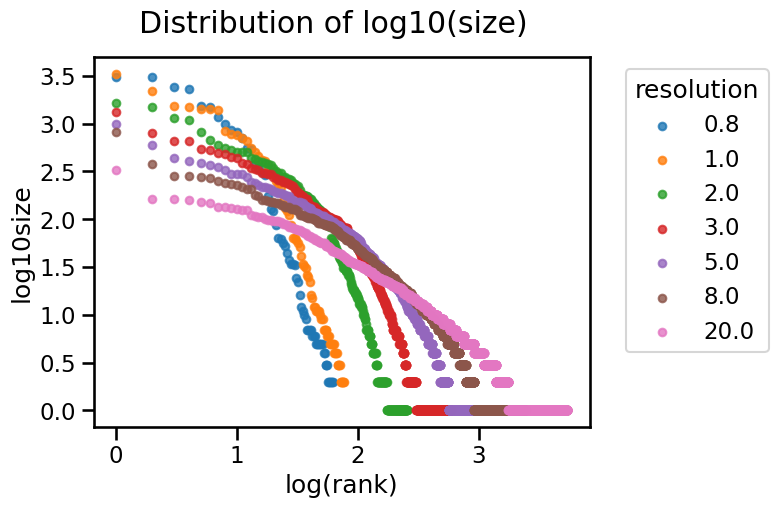

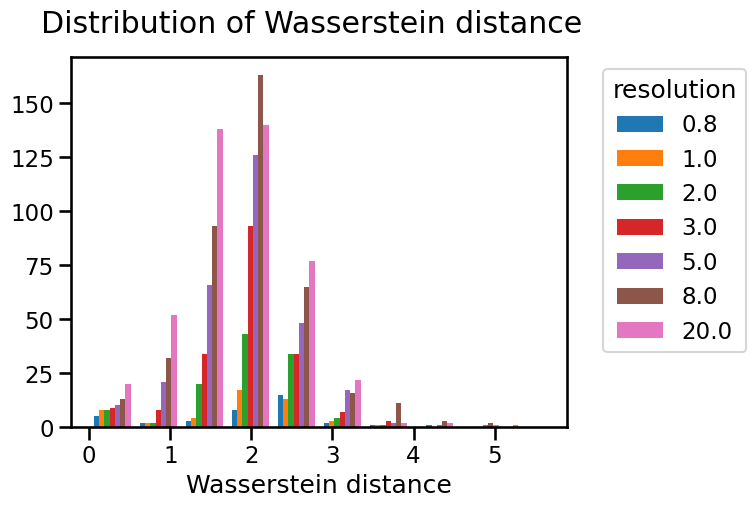

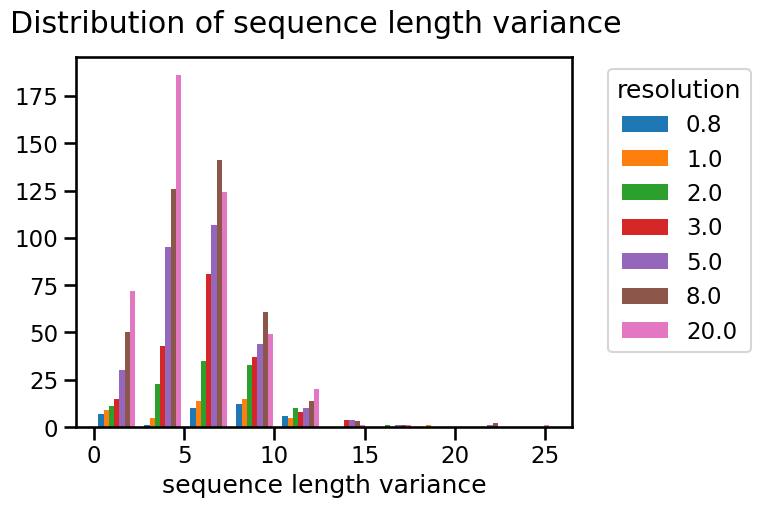

In [61]:
# plot the statistics for the different clusters from different resolutions
# master_data = [master_n_unique_subjects, master_size, master_wasserstein]
stat_to_data = {} # values are data lists
stat_to_name = {} # values are strings for printing
stat_to_data["n_unique_subjects"] = master_n_unique_subjects
stat_to_name["n_unique_subjects"] = "# of unique subjects"
stat_to_data["size"] = master_size
stat_to_name["size"] = "size"
stat_to_data["log10size"] = [np.log10(s) for s in master_size] # synthetic
stat_to_name["log10size"] = "log10(size)"
stat_to_data["wasserstein_dist"] = master_wasserstein
stat_to_name["wasserstein_dist"] = "Wasserstein distance"
stat_to_data["seq_variance"] = master_seq_variance
stat_to_name["seq_variance"] = "sequence length variance"


for stat in stat_to_data.keys():
    # stat = "n_unique_subjects"
    stat_name = stat_to_name[stat]
    stat_data = stat_to_data[stat]
    file_location = "plots/"
    file_name = "louvain_" + stat + "_dist.png"

    # create plots
    if stat == "log10size" or stat == "size":
        # scatterplot
        fig, ax = plt.subplots()
        for y, res in zip(stat_data, resolutions):
            y_sorted = list(y)
            y_sorted.sort(reverse=True)
            x = [np.log10(i) for i in range(1, len(y)+1)]
            ax.scatter(x, y_sorted, label=res, s=30, alpha=0.8)
        plt.xlabel("log(rank)")
        plt.ylabel(stat)

    else:
        # histogram
        plt.hist(stat_data, bins=10, label=resolutions) # data in same order as resolutions
        plt.xlabel(stat_name)

    # save without legend
    plt.suptitle("Distribution of " + stat_name)
    file_save = file_location + "nolegend_" + file_name
    # plt.savefig(file_save, bbox_inches='tight', dpi=300)

    # add legend and save
    plt.legend(title="resolution", bbox_to_anchor=(1.05, 1), loc='upper left')
    file_save = file_location + file_name
    # plt.savefig(file_save, bbox_inches='tight', dpi=300)

    # show plots in vs code
    plt.show()
    # plt.close()

Plot of size with sequence variance. Hopefuly find big variable clusters are broken down.

In [ ]:
# x = master_size_no_smalls
# y = master_seq_variance or master_wasserstein
# color by resolution.

fig, ax = plt.subplots()
for x, y, res in zip(master_size_no_smalls, master_seq_variance, resolutions):
    ax.scatter(x, y_sorted, label=res, s=30, alpha=0.8)
    
plt.legend(title="resolution", bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.xlabel("size")
plt.ylabel("sequence length variance")
plt.title("Size and Sequence Length Variance of Clusters")
plt.show()

### Plot all clusters at different resolutions

In [153]:
G = G_full
# resolutions = [0.8, 1.0, 2.0, 3.0, 5.0, 8.0, 20.0]
resolutions = [5.0]

for res in resolutions:
    outer_cc_id = 0
    for outer_cc in nx.connected_components(G):
        cc_subgraph = G.subgraph(outer_cc)

        louvain_partition = nx.community.louvain_communities(cc_subgraph, weight="linear_similarity", resolution = res, seed=17) 

        # partition id contains resolution and outer cc id (since func assigns new ids)
        partition_id = "res" + str(res) + "_outercc" + str(outer_cc_id)

        # file_path = "res_cluster_images"
        file_path = "bigger_res_cluster_images" # bigger dots in images

        plot_all_clusters(cc_subgraph, louvain_partition, file_path, partition_id)

        outer_cc_id += 1
    

# Compute cluster statistics and run tests

### Computing statistics

In [111]:
# takes in subgraph of the community
# returns df row with data of the community
def compute_community_stats(subgraph, community_id, resolution, distance_func, distance_threshold):
    community = subgraph.nodes() # get the nodes

    # --- store data in dict; to map to dataframe --- #
    community_data_dict = dict()

    # --- id --- #
    # community_id = "community" + str(community_id_counter)
    community_data_dict["community_id"] = community_id
    community_data_dict["resolution"] = resolution

    # --- nodes --- #
    community_data_dict["node_set"] = [community]

    # --- size (n_nodes) --- #
    community_data_dict["size"] = len(community)

    # ---- LISI --- #
    community_subgraph = subgraph # passed in; so dont have to rewrite code
    node_to_lisi_dict, lisi_df = my_lisi.compute_lisi_metrics(community_subgraph, k=None, perplexity=None) # use default k, perplexity
    # TO IMPLEMENT: add in lisi scores to graph if needed
    community_median_lisi = np.median(list(node_to_lisi_dict.values()))
    community_data_dict["median_lisi"] = community_median_lisi
    # print(community_median_lisi) # use median? or mean? 
    community_mean_lisi = np.mean(list(node_to_lisi_dict.values()))
    community_data_dict["mean_lisi"] = community_mean_lisi

    # --- Inverse Simpson's Index (cf.) --- #
    community_data_dict["inverse_simpsons_index"] = my_lisi.compute_naive_simpson_index(community_subgraph)

    # --- number of unique subjects --- 
    subject_ids_dict = nx.get_node_attributes(subgraph, "subject_id")
    unique_subjects_set = set(subject_ids_dict.values())
    community_data_dict["n_unique_subjects"] = len(unique_subjects_set)

    # --- average degree --- #
    community_data_dict["average_degree"] = 2 * len(subgraph.edges) / len(subgraph.nodes) # correlated with size. 
    community_data_dict["average_degree_norm"] = 2 * len(subgraph.edges) / (len(subgraph.nodes)**2) # neg corr with size
    
    # ----- healthy data stats ----- #
    control_subject_ids = set()
    control_node_count = 0
    control_nodes = set()
    for node in community:
        node_subject_id = community[node]["subject_id"]
        node_data_type = community[node]["data_type"]
        # node_sequence = community[node]["junction_aa_clipped"] # unused atm
        if node_data_type == "control":
            control_subject_ids.add(node_subject_id)
            control_node_count += 1
            control_nodes.add(node)


    community_data_dict["n_control_subjects"] = len(control_subject_ids)
    community_data_dict["n_control_nodes"] = control_node_count
    community_data_dict["control_nodes"] = [control_nodes]

    community_data_dict["prop_control"] = control_node_count / len(community)
    community_data_dict["prop_patient"] = 1 - community_data_dict["prop_control"]

    # can have a binary predictor variable as well with some cutoff


    # ----- annotated data (y-variable) ----- #
    close_annotated_sequences = set()
    for known_binder in annotated_sequences:
        for node in community:
            seq_node_dist = distance_func(known_binder, community_subgraph.nodes[node]["junction_aa_clipped"], edge_cutoff=distance_threshold)
            if seq_node_dist <= distance_threshold:
                close_annotated_sequences.add(known_binder)
                continue # can remove if need to check multiple nodes
    
    if len(close_annotated_sequences) > 0:
        community_data_dict["close_annotated_sequences"] = [close_annotated_sequences]
    else:
        community_data_dict["close_annotated_sequences"] = "None"

    community_data_dict["n_close_annotated_sequences"] = len(close_annotated_sequences)
    community_data_dict["has_close_annotated_sequence"] = 1 * (len(close_annotated_sequences) > 0)  # for logistic prediction


    # --- append data to master community dataframe --- #
    community_df_row = pd.DataFrame.from_dict(community_data_dict)

    return community_df_row

#### Run computations

In [112]:
# ----- changeable parameters ----- #
G = G_full

annotated_sequences = annotated_sequences 
distance_func = my_dist.levenshtein_distance_norm 
# louvain_weight = "louvain_weight"
louvain_weight = "linear_similarity"
distance_threshold = 0.2 # 0.35

resolutions = [1.0, 2.0, 3.0, 5.0, 8.0, 20.0] # all
# resolutions = [2.0, 3.0]

# store community (smallest group size; post Louvain) information in a master df
community_data = pd.DataFrame()

# def test(community_data=community_data):
# for each resolution, run a test
for res in resolutions:

    # looping over connected components of main graph, contains nodes with the same v, j gene
    community_id_counter = 0
    for cc in nx.connected_components(G):
        # small optimization
        if len(cc) < 10:
            continue

        # create induced subgraph
        cc_subgraph = G.subgraph(cc)

        # compute Louvain partition with given resolution
        louvain_partition = nx.community.louvain_communities(cc_subgraph, weight=louvain_weight, resolution = res, seed=17)
        # print("done partitioning")

        # for each cluster:
        for community_partition in louvain_partition:
            # for extracting cc, since Louvain can return disconnected communities somehow
            temp_subgraph = cc_subgraph.subgraph(community_partition) 
            for community in nx.connected_components(temp_subgraph):
                # filter out the small ones
                if len(community) < 10: # < 1000
                    continue

                comunity_subgraph = temp_subgraph.subgraph(community)
                community_id = "community" + str(community_id_counter)

                # compute row of statistics with helper function
                # subgraph, community_id, resolution, distance_func, distance_threshold
                community_data_row = compute_community_stats(comunity_subgraph, community_id, res, distance_func=distance_func, distance_threshold=distance_threshold)
                # community_data_row = compute_lisi_stats(comunity_subgraph, community_id, res)

                community_data = pd.concat([community_data, community_data_row])

                community_id_counter += 1


community_data = community_data.reset_index(drop=True)



#### Save to file 

In [73]:
# community_data.to_csv("alt_raw_community_data.csv") # use this
# community_data.to_csv("raw_community_data.csv")

### Process Final Dataset

In [114]:
# ----- read in csv ----- #
# community_data = pd.read_csv("alt_raw_community_data.csv") # reset
preprocessed_df = community_data
preprocessed_df["node_set"] = preprocessed_df["node_set"]
preprocessed_df["size"] = pd.to_numeric(preprocessed_df["size"])
preprocessed_df["log10size"] = preprocessed_df["size"].map(np.log10)
preprocessed_df.head()


,community_id,resolution,node_set,size,median_lisi,mean_lisi,inverse_simpsons_index,n_unique_subjects,average_degree,average_degree_norm,n_control_subjects,n_control_nodes,control_nodes,prop_control,prop_patient,close_annotated_sequences,n_close_annotated_sequences,has_close_annotated_sequence,log10size
0,community0,1.0,"(14146, 9731, 10852, 16487, 6637, 11599, 949, ...",12,2.129746,2.186554,6.545455,8,2.333333,0.194444,0,0,{},0.000000,1.000000,{AAMYYYDSSGYYNWFDP},1,1,1.079181
1,community1,1.0,"(17561, 10853, 231, 20895, 7087, 9808, 19121, ...",18,3.112394,3.214518,7.363636,11,2.888889,0.160494,5,7,"{18937, 19121, 17560, 17561, 18938, 21947, 20895}",0.388889,0.611111,None,0,0,1.255273
2,community2,1.0,"(10208, 12961, 2499, 6052, 6053, 6054, 6055, 6...",11,1.121698,1.362859,3.666667,6,5.090909,0.462810,1,1,{21949},0.090909,0.909091,None,0,0,1.041393
3,community3,1.0,"(2498, 2500, 2501, 3751, 10860, 9614, 9615, 84...",13,2.407966,2.458982,5.827586,7,2.307692,0.177515,1,1,{19318},0.076923,0.923077,None,0,0,1.113943
4,community4,1.0,"(3750, 20425, 7082, 943, 8946, 15123, 17559, 1...",10,2.152094,2.189172,8.333333,9,2.000000,0.200000,2,2,"{20425, 17559}",0.200000,0.800000,None,0,0,1.000000


In [116]:
# ----- [dupe for now] add in close annotated sequence data ----- #
# community_data_processed = community_data
community_data_processed = preprocessed_df # from previous cell

# thresholds = [0.175, 0.2, 0.25, 0.3, 0.35] # use if testing multiple thresholds
thresholds = [0.2]
G = G_full

# create new columns for close annotated sequences by multiple thresholds
for threshold in thresholds:
    # community_data_processed["close_annotated_sequences"] = ""
    n_close_name = "n_close_annotated_sequences" + str(threshold)
    has_close_name = "has_close_annotated_sequence" + str(threshold)

    for index, row in community_data_processed.iterrows():
        community_nodes = row["node_set"]

        # check for close annotated sequences
        close_annotated_sequences = set()
        for known_binder in annotated_sequences:
            for node in community_nodes:
                node_seq = G.nodes[int(node)]["junction_aa_clipped"] # str --> int
                seq_node_dist = distance_func(known_binder, node_seq, edge_cutoff=threshold)

                if seq_node_dist <= threshold:
                    close_annotated_sequences.add(known_binder)
                    # continue # can use if need to check multiple nodes

        community_data_processed.at[index, n_close_name] = len(close_annotated_sequences)
        community_data_processed.at[index, has_close_name] = 1 * (len(close_annotated_sequences) > 0)


# community_data_processed = community_data_processed.reset_index(drop=True)

community_data_processed.head()

,community_id,resolution,node_set,size,median_lisi,mean_lisi,inverse_simpsons_index,n_unique_subjects,average_degree,average_degree_norm,...,n_control_nodes,control_nodes,prop_control,prop_patient,close_annotated_sequences,n_close_annotated_sequences,has_close_annotated_sequence,log10size,n_close_annotated_sequences0.2,has_close_annotated_sequence0.2
0,community0,1.0,"(14146, 9731, 10852, 16487, 6637, 11599, 949, ...",12,2.129746,2.186554,6.545455,8,2.333333,0.194444,...,0,{},0.000000,1.000000,{AAMYYYDSSGYYNWFDP},1,1,1.079181,1.0,1.0
1,community1,1.0,"(17561, 10853, 231, 20895, 7087, 9808, 19121, ...",18,3.112394,3.214518,7.363636,11,2.888889,0.160494,...,7,"{18937, 19121, 17560, 17561, 18938, 21947, 20895}",0.388889,0.611111,None,0,0,1.255273,0.0,0.0
2,community2,1.0,"(10208, 12961, 2499, 6052, 6053, 6054, 6055, 6...",11,1.121698,1.362859,3.666667,6,5.090909,0.462810,...,1,{21949},0.090909,0.909091,None,0,0,1.041393,0.0,0.0
3,community3,1.0,"(2498, 2500, 2501, 3751, 10860, 9614, 9615, 84...",13,2.407966,2.458982,5.827586,7,2.307692,0.177515,...,1,{19318},0.076923,0.923077,None,0,0,1.113943,0.0,0.0
4,community4,1.0,"(3750, 20425, 7082, 943, 8946, 15123, 17559, 1...",10,2.152094,2.189172,8.333333,9,2.000000,0.200000,...,2,"{20425, 17559}",0.200000,0.800000,None,0,0,1.000000,0.0,0.0


In [119]:
# ----- add in additional variables: clustering coefficient, wasserstein, variance ----- #
# easy with node set stored in df
G = G_full
df = community_data_processed

for index, row in community_data_processed.iterrows():
    nodes = [int(node) for node in row["node_set"]] # string to int
    subgraph = G.subgraph(nodes)

    # average clustering
    average_clustering = nx.average_clustering(subgraph)
    df.at[index, "average_clustering"] = average_clustering

    # wasserstein
    subgraph_sequences = nx.get_node_attributes(subgraph, "junction_aa_clipped")
    sequence_lengths = [len(seq) for seq in subgraph_sequences.values()]
    mode_length = [scipy.stats.mode(sequence_lengths).mode] # extract mode
    wasserstein_dist = scipy.stats.wasserstein_distance(sequence_lengths, mode_length)

    df.at[index, "wasserstein"] = wasserstein_dist

    # variance
    seq_length_variance = np.var(sequence_lengths)

    df.at[index, "seq_length_variance"] = seq_length_variance


community_data_processed.head()


,community_id,resolution,node_set,size,median_lisi,mean_lisi,inverse_simpsons_index,n_unique_subjects,average_degree,average_degree_norm,...,prop_patient,close_annotated_sequences,n_close_annotated_sequences,has_close_annotated_sequence,log10size,n_close_annotated_sequences0.2,has_close_annotated_sequence0.2,average_clustering,wasserstein,seq_length_variance
0,community0,1.0,"(14146, 9731, 10852, 16487, 6637, 11599, 949, ...",12,2.129746,2.186554,6.545455,8,2.333333,0.194444,...,1.000000,{AAMYYYDSSGYYNWFDP},1,1,1.079181,1.0,1.0,0.366667,1.833333,4.833333
1,community1,1.0,"(17561, 10853, 231, 20895, 7087, 9808, 19121, ...",18,3.112394,3.214518,7.363636,11,2.888889,0.160494,...,0.611111,None,0,0,1.255273,0.0,0.0,0.444444,1.222222,2.246914
2,community2,1.0,"(10208, 12961, 2499, 6052, 6053, 6054, 6055, 6...",11,1.121698,1.362859,3.666667,6,5.090909,0.462810,...,0.909091,None,0,0,1.041393,0.0,0.0,0.615584,0.363636,0.727273
3,community3,1.0,"(2498, 2500, 2501, 3751, 10860, 9614, 9615, 84...",13,2.407966,2.458982,5.827586,7,2.307692,0.177515,...,0.923077,None,0,0,1.113943,0.0,0.0,0.233333,3.384615,20.248521
4,community4,1.0,"(3750, 20425, 7082, 943, 8946, 15123, 17559, 1...",10,2.152094,2.189172,8.333333,9,2.000000,0.200000,...,0.800000,None,0,0,1.000000,0.0,0.0,0.166667,0.900000,1.450000


In [120]:
community_data_processed.shape

(1287, 24)

In [33]:
# community_data_processed.to_csv("community_data_processed.csv")
# community_data_processed.to_csv("alt_community_data_processed.csv") # use this

### Plot boxplots of individual statistics against has_close_annotated_node

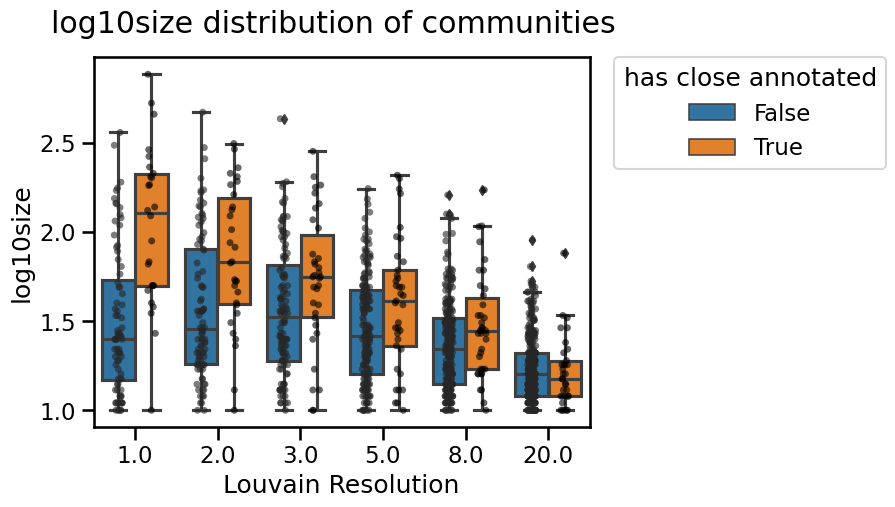

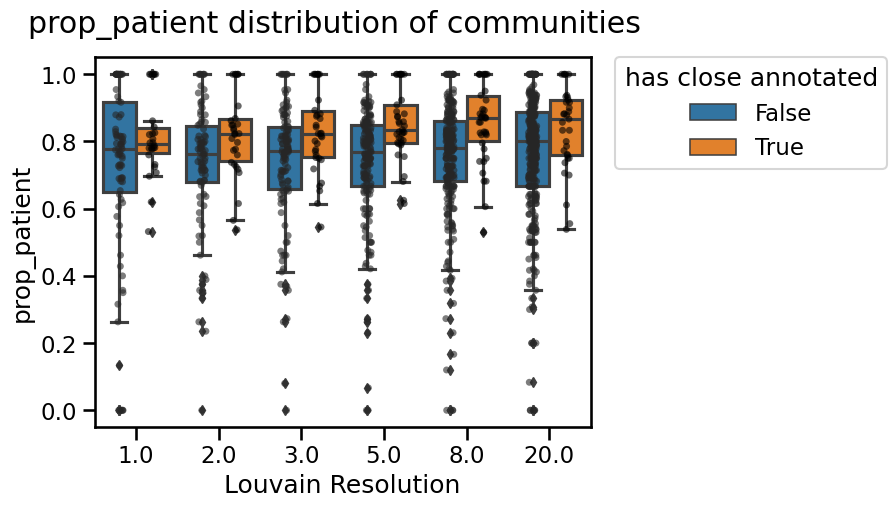

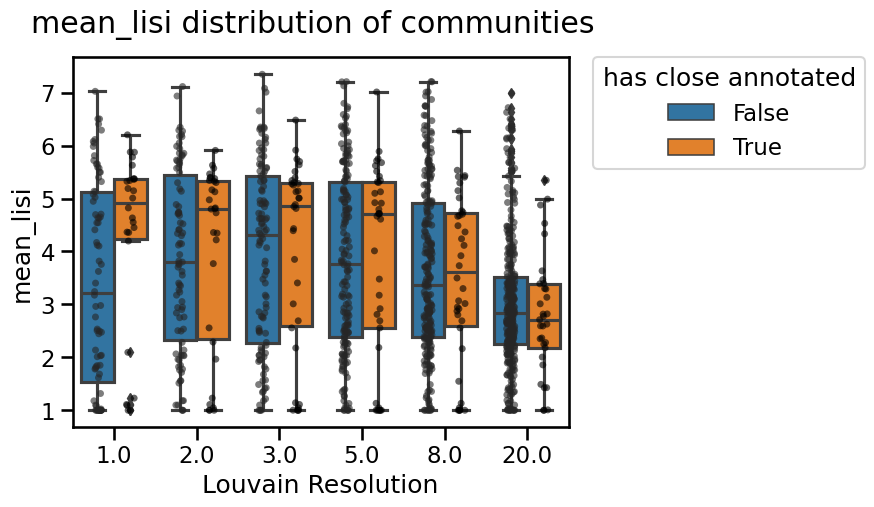

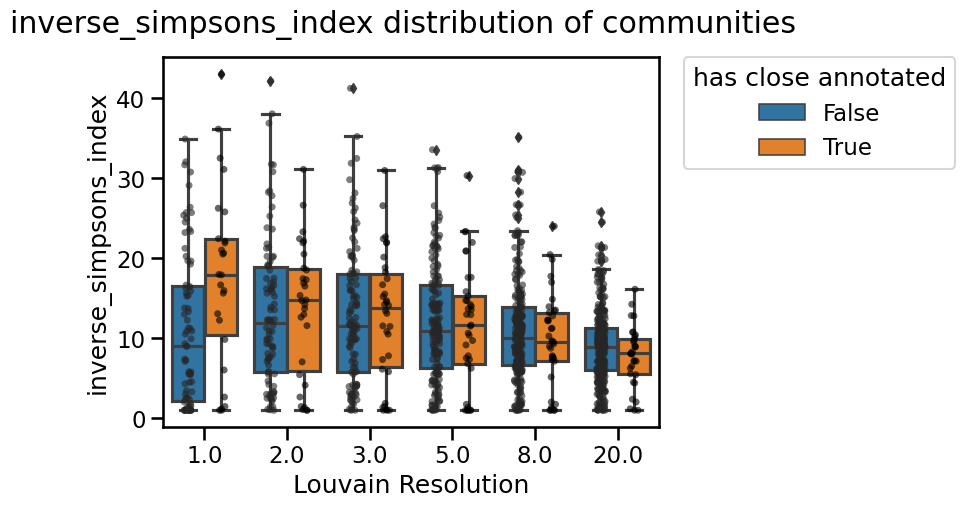

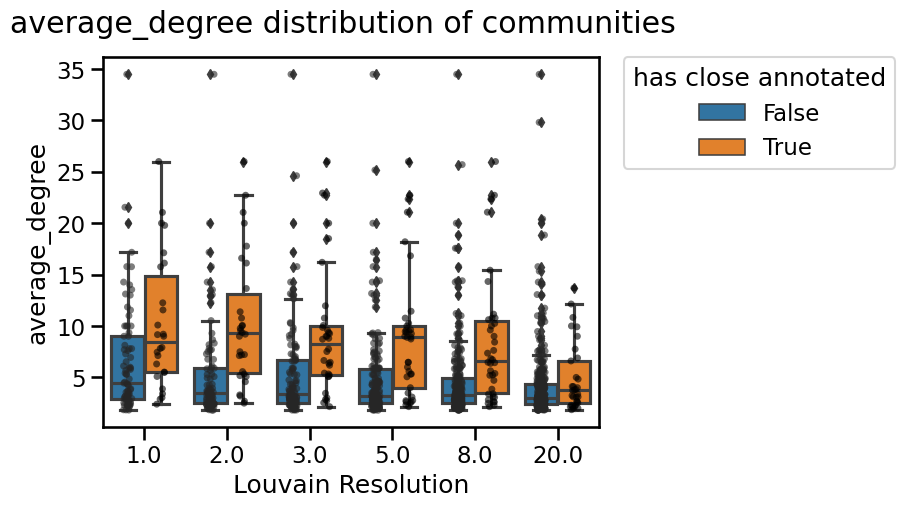

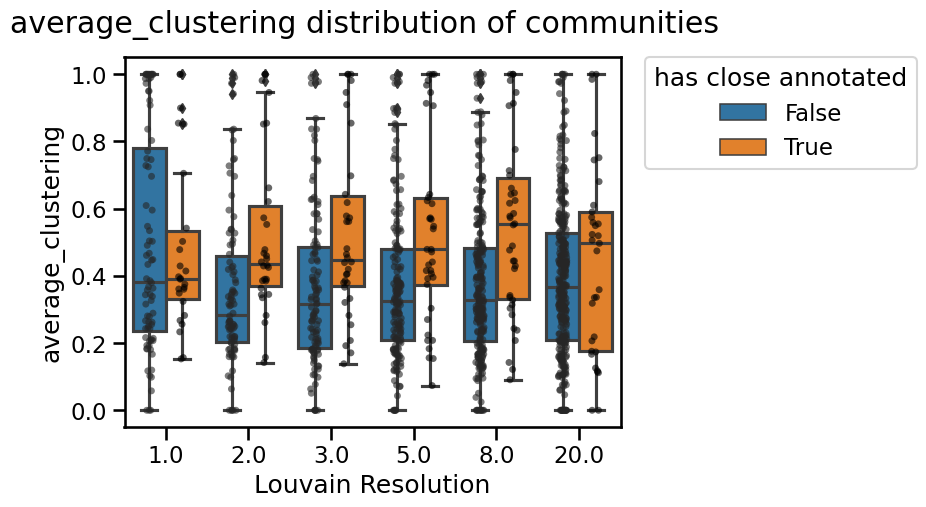

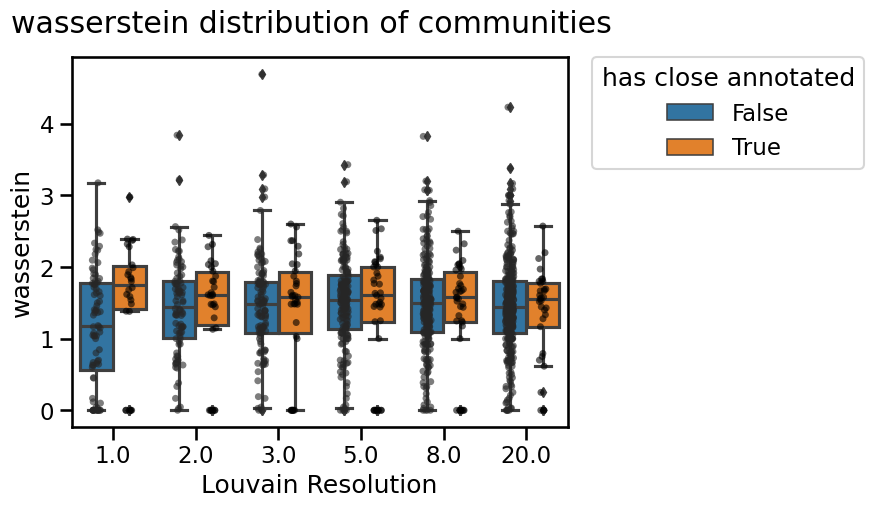

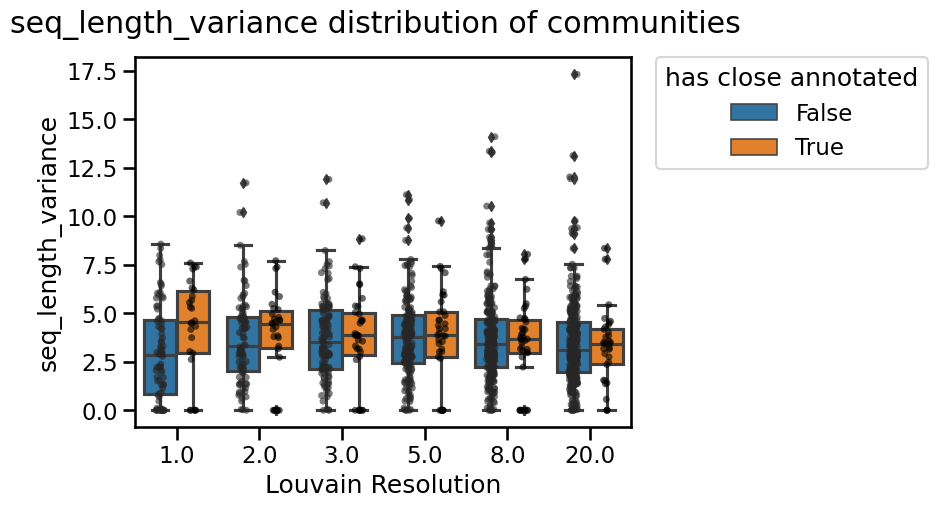

In [128]:
temp_data = pd.read_csv("alt_community_data_processed.csv")

# to implement?: make all these plots and save them as files; 1 loop
stat_list = ['log10size', 
             'prop_patient', 
             'mean_lisi', 'inverse_simpsons_index', 
             'average_degree', 'average_clustering', 
             'wasserstein', 'seq_length_variance']
             
has_annotated_sequence = "has_close_annotated_sequence0.2"
# data = community_data_processed
data = temp_data

for stat in stat_list:
    ax = sns.boxplot(x='resolution', y=stat, hue=has_annotated_sequence, data=data)
    ax = sns.stripplot(x='resolution', y=stat, hue=has_annotated_sequence, data=data, alpha=0.6, ax=ax, dodge=True, color='black')

    # remove legend labels for scatterplot
    h, l = ax.get_legend_handles_labels()
    l_tf = [bool(int(float(label))) for label in l] # convert 0/1 to T/F 
    plt.legend(h[0:2], l_tf[0:2], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="has close annotated")

    plt.suptitle(stat + " distribution of communities")
    plt.ylabel(stat)
    plt.xlabel("Louvain Resolution")

    # save file with legend
    file_name = "new_plots/" + stat + "_boxplot_" + has_annotated_sequence + ".png"
    # plt.savefig(file_name, bbox_inches='tight', dpi=300)

    # save file without legend
    ax.get_legend().remove()
    file_name = "new_plots/" + stat + "_nolegend_boxplot_" + has_annotated_sequence + ".png"
    # plt.savefig(file_name, bbox_inches='tight', dpi=300)

    # add legend back in
    plt.legend(h[0:2], l_tf[0:2], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="has close annotated")
    plt.show()


### Compute Wilcoxon Rank-Sum test statistics and p-values. 

In [127]:
# stats = ["mean_lisi", "median_lisi", "inverse_simpsons_index", "size"]

# df = community_data_processed
df = temp_data
has_close_annotated = "has_close_annotated_sequence0.2"
resolutions = np.unique(community_data_processed["resolution"])

negative_data = df[df[has_close_annotated] == 0]
positive_data = df[df[has_close_annotated] == 1]

for stat in stat_list: # stat list from previous cell
    stat_ranksum_stats = []
    stat_ranksum_stats_print = []
    for res in resolutions:
        negative_community_stat = negative_data[negative_data["resolution"] == res][stat]
        positive_community_stat = positive_data[positive_data["resolution"] == res][stat]

        if stat == 'prop_control':
            ranksum_stat, pvalue = scipy.stats.ranksums(negative_community_stat, positive_community_stat, alternative="greater")
        else:
            ranksum_stat, pvalue = scipy.stats.ranksums(negative_community_stat, positive_community_stat, alternative="less")

        stat_ranksum_stats.append([res, ranksum_stat, pvalue])

        # format stats for printing
        ranksum_stat_formatted = '{:0.4}'.format(ranksum_stat)
        if pvalue<0.0001:
            pvalue_formatted = '{:0.3e}'.format(pvalue)
        else:
            pvalue_formatted = '{:0.4}'.format(pvalue)
        stat_ranksum_stats_print.append([res, ranksum_stat_formatted, pvalue_formatted])
        

    to_print = f"{stat} results: " + str(stat_ranksum_stats_print)
    if stat == 'prop_control': # special variable
        to_print = '*' + to_print
    print(to_print)

print('* indicates we expect negative correlation')


log10size results: [[1.0, '-4.909', '4.584e-07'], [2.0, '-3.433', '0.0002981'], [3.0, '-2.47', '0.006753'], [5.0, '-2.202', '0.01383'], [8.0, '-2.065', '0.01948'], [20.0, '0.5288', '0.7015']]
prop_patient results: [[1.0, '-1.131', '0.1291'], [2.0, '-2.445', '0.007233'], [3.0, '-2.641', '0.004128'], [5.0, '-3.998', '3.201e-05'], [8.0, '-3.855', '5.793e-05'], [20.0, '-2.434', '0.007468']]
mean_lisi results: [[1.0, '-1.883', '0.02982'], [2.0, '-0.3455', '0.3649'], [3.0, '-0.1482', '0.4411'], [5.0, '-0.06176', '0.4754'], [8.0, '0.2283', '0.5903'], [20.0, '0.8601', '0.8051']]
inverse_simpsons_index results: [[1.0, '-2.625', '0.004331'], [2.0, '-0.4848', '0.3139'], [3.0, '-0.1065', '0.4576'], [5.0, '0.2229', '0.5882'], [8.0, '0.7379', '0.7697'], [20.0, '1.235', '0.8916']]
average_degree results: [[1.0, '-2.992', '0.001385'], [2.0, '-4.852', '6.126e-07'], [3.0, '-4.304', '8.402e-06'], [5.0, '-4.626', '1.868e-06'], [8.0, '-4.75', '1.016e-06'], [20.0, '-1.331', '0.09162']]
average_clustering re

In [125]:
# community_data_processed.to_csv("newest_community_data_processed.csv")

# Logistic Regression

Continued on R markdown file